In [ ]:
!pip install -r requirements.txt # run this cell to install all the packages needed 

In [17]:
#import of libraries 

import os
import webbrowser
import s3fs
import matplotlib


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cftime
import plotly.graph_objects as go
import calendar

import contextily as ctx
import folium
from folium import LayerControl
import geopandas as gpd

from shapely.geometry import Polygon, LineString, Point
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import xarray as xr
import netCDF4 as nc
from netCDF4 import Dataset
from IPython.display import display

In [3]:
# Creation of two folders to centralize data and results
data_dir = "./data"  
os.makedirs(data_dir, exist_ok=True) 
results_dir = "./results"
os.makedirs(results_dir, exist_ok=True)


# Access information to the cloud MinIO Client (Eve's bucket)
fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})
MY_BUCKET = "esam"

In [6]:
import os
import pandas as pd

# Répertoire contenant les fichiers CSV
csv_directory = "./downloaded_csv_files"

# Liste pour stocker les DataFrames
dataframes = []

# Itérer sur tous les fichiers CSV dans le répertoire
for file_name in os.listdir(csv_directory):
    if file_name.endswith(".csv"):  # Vérifier si le fichier est un CSV
        file_path = os.path.join(csv_directory, file_name)
        
        # Charger le fichier CSV
        df = pd.read_csv(file_path)
        dataframes.append(df)

# Combiner tous les DataFrames en un seul
combined_df = pd.concat(dataframes, ignore_index=True)

# Afficher un aperçu du DataFrame combiné
print("Combined DataFrame preview:")
print(combined_df.head())

# Sauvegarder le DataFrame combiné dans un fichier CSV
combined_output_path = os.path.join(csv_directory, "combined_data.csv")
combined_df.to_csv(combined_output_path, index=False)



Combined DataFrame preview:
   dataset_id     scientific_name      common_name site_name colony_name  \
0        1128  Fratercula arctica  Atlantic Puffin   Iceland      Flatey   
1        1128  Fratercula arctica  Atlantic Puffin   Iceland      Flatey   
2        1128  Fratercula arctica  Atlantic Puffin   Iceland      Flatey   
3        1128  Fratercula arctica  Atlantic Puffin   Iceland      Flatey   
4        1128  Fratercula arctica  Atlantic Puffin   Iceland      Flatey   

   lat_colony  lon_colony device  bird_id            track_id  ...    age  \
0       65.37      -22.92    GLS  V491716  1128_V491716_75204  ...  adult   
1       65.37      -22.92    GLS  V491716  1128_V491716_75204  ...  adult   
2       65.37      -22.92    GLS  V491716  1128_V491716_75204  ...  adult   
3       65.37      -22.92    GLS  V491716  1128_V491716_75204  ...  adult   
4       65.37      -22.92    GLS  V491716  1128_V491716_75204  ...  adult   

       sex breed_stage  breed_status    date_gmt  ti

In [9]:
# Afficher les noms des colonnes
print("Columns in the DataFrame:")
print(combined_df.columns)

# Aperçu rapide des premières lignes
#print("Preview of the data:")
#print(combined_df.head())

# Rechercher des colonnes avec des mots-clés pertinents
keywords = ['reproduction', 'production', 'rate', 'survival', 'breeding', 'nests', 'breed']
relevant_columns = [col for col in combined_df.columns if any(keyword in col.lower() for keyword in keywords)]

print("Relevant columns related to reproduction:")
print(relevant_columns)



Columns in the DataFrame:
Index(['dataset_id', 'scientific_name', 'common_name', 'site_name',
       'colony_name', 'lat_colony', 'lon_colony', 'device', 'bird_id',
       'track_id', 'original_track_id', 'age', 'sex', 'breed_stage',
       'breed_status', 'date_gmt', 'time_gmt', 'latitude', 'longitude',
       'argos_quality', 'equinox'],
      dtype='object')
Relevant columns related to reproduction:
['breed_stage', 'breed_status']


Statistical summary of relevant columns:
          breed_stage breed_status
count           48092        48092
unique              4            3
top     chick-rearing     breeding
freq            19630        19630


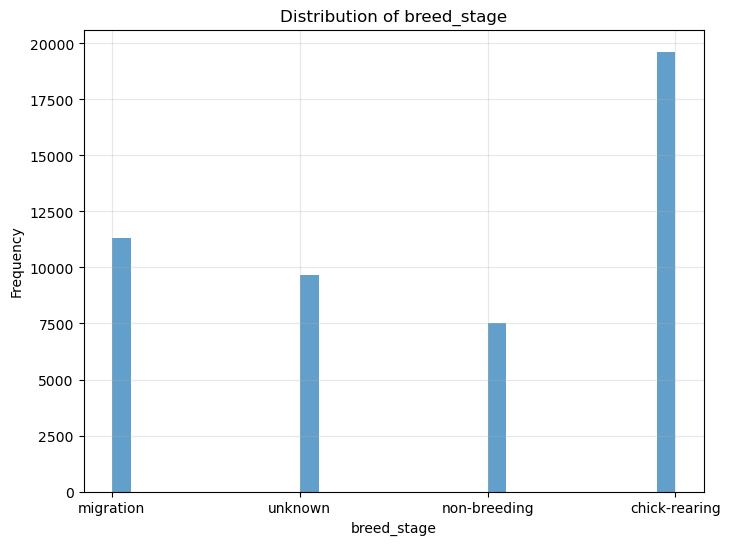

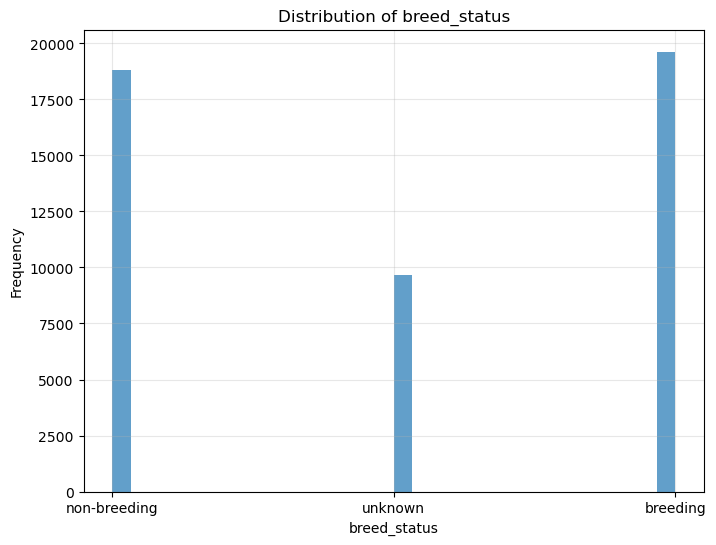

In [11]:
# Résumé statistique des colonnes pertinentes
if relevant_columns:
    print("Statistical summary of relevant columns:")
    print(combined_df[relevant_columns].describe())
else:
    print("No relevant columns found.")


import matplotlib.pyplot as plt

for col in relevant_columns:
    plt.figure(figsize=(8, 6))
    combined_df[col].hist(bins=30, alpha=0.7)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid(alpha=0.3)
    plt.show()



In [14]:
# Convertir la colonne 'date_gmt' en datetime si ce n'est pas déjà fait
combined_df['date_gmt'] = pd.to_datetime(combined_df['date_gmt'])

# Vérifier les premières valeurs pour s'assurer de la conversion
print(combined_df['date_gmt'].head())

# Extraire l'année, le mois, ou la saison
combined_df['Year'] = combined_df['date_gmt'].dt.year
combined_df['Month'] = combined_df['date_gmt'].dt.month
combined_df['Day'] = combined_df['date_gmt'].dt.day
combined_df['Season'] = combined_df['date_gmt'].dt.month % 12 // 3 + 1  # 1: hiver, 2: printemps, 3: été, 4: automne

# Aperçu des colonnes ajoutées
print(combined_df[['date_gmt', 'Year', 'Month', 'Day', 'Season']].head())



0   2008-10-27
1   2008-10-29
2   2008-10-27
3   2008-10-26
4   2008-10-12
Name: date_gmt, dtype: datetime64[ns]
    date_gmt  Year  Month  Day  Season
0 2008-10-27  2008     10   27       4
1 2008-10-29  2008     10   29       4
2 2008-10-27  2008     10   27       4
3 2008-10-26  2008     10   26       4
4 2008-10-12  2008     10   12       4


Breed status counts by year:
breed_status  breeding  non-breeding  unknown
Year                                         
2007                 0          4704        0
2008                 0          5094        0
2009                 0           608        0
2010                 0           568        0
2011                 0           304        0
2012                 0            20        0
2013                 0          5408        0
2014                 0          2092     5166
2015                 0             0     4498
2018             19630             0        0


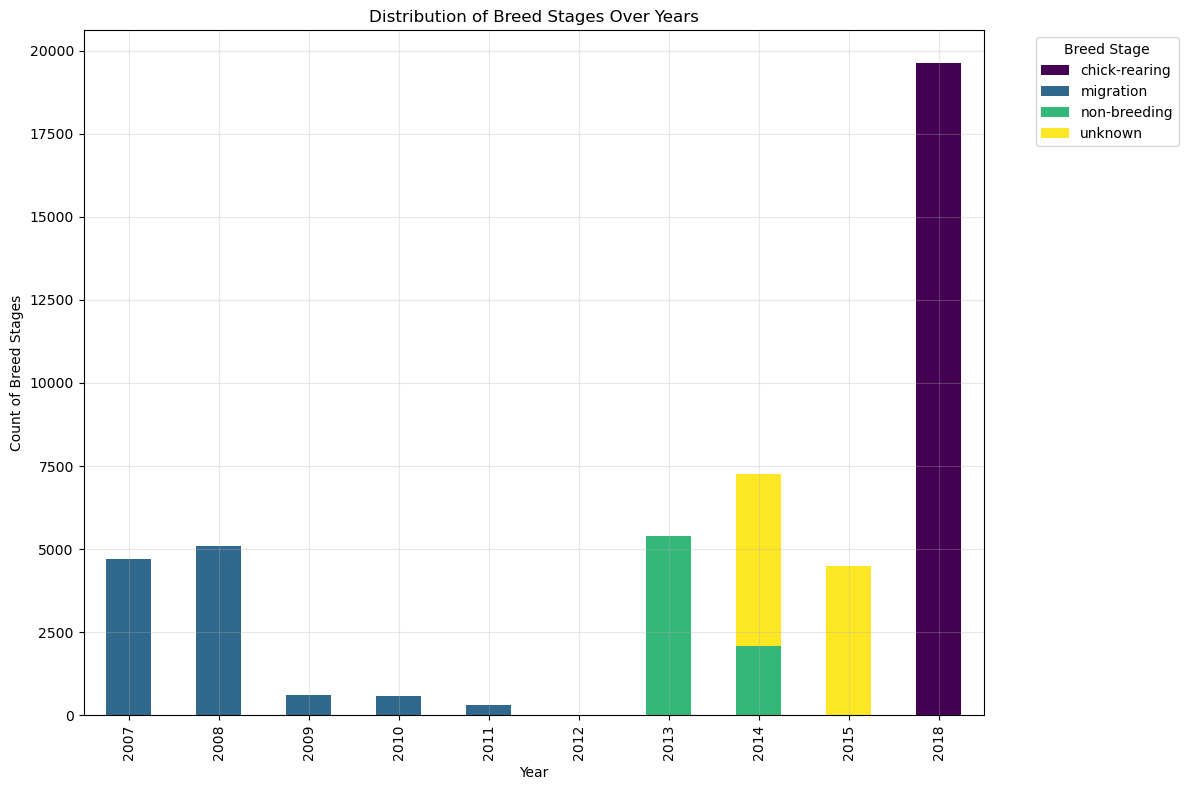

In [23]:
# Convertir 'date_gmt' en datetime si ce n'est pas déjà fait
combined_df['date_gmt'] = pd.to_datetime(combined_df['date_gmt'])

# Extraire l'année à partir de 'date_gmt'
combined_df['Year'] = combined_df['date_gmt'].dt.year


# Compter les occurrences de chaque 'breed_stage' par année
breed_stage_counts = combined_df.groupby(['Year', 'breed_stage']).size().unstack(fill_value=0)
breed_status_counts = combined_df.groupby(['Year', 'breed_status']).size().unstack(fill_value=0)

# Afficher les résultats
#print("Breed stage counts by year:")
#print(breed_stage_counts.head(20))
print("Breed status counts by year:")
print(breed_status_counts.head(20))

# Graphique en barres empilées pour la distribution des 'breed_stage' par année
breed_stage_counts.plot(kind='bar', stacked=True, figsize=(12, 8), cmap='viridis')
plt.title("Distribution of Breed Stages Over Years")
plt.xlabel("Year")
plt.ylabel("Count of Breed Stages")
plt.legend(title="Breed Stage", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
